In [106]:
from dataclasses import dataclass
from typing import Optional, Union, List
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw

import utils
from prevsoln import *

MAIN = __name__ == "__main__"

In [107]:
# MAIN = __name__ == "__main__"
# Arr = np.ndarray

# if MAIN:
#     import prevutils as utils

# # %%
# class Environment:
#     def __init__(self, num_states: int, num_actions: int, start=0, terminal=None):
#         self.num_states = num_states
#         self.num_actions = num_actions
#         self.start = start
#         self.terminal = np.array([], dtype=int) if terminal is None else terminal
#         (self.T, self.R) = self.build()

#     def build(self):
#         '''
#         Constructs the T and R tensors from the dynamics of the environment.
#         Outputs:
#             T : (num_states, num_actions, num_states) State transition probabilities
#             R : (num_states, num_actions, num_states) Reward function
#         '''
#         num_states = self.num_states
#         num_actions = self.num_actions
#         T = np.zeros((num_states, num_actions, num_states))
#         R = np.zeros((num_states, num_actions, num_states))
#         for s in range(num_states):
#             for a in range(num_actions):
#                 (states, rewards, probs) = self.dynamics(s, a)
#                 (all_s, all_r, all_p) = self.out_pad(states, rewards, probs)
#                 T[s, a, all_s] = all_p
#                 R[s, a, all_s] = all_r
#         return (T, R)

#     def dynamics(self, state: int, action: int) -> tuple[Arr, Arr, Arr]:
#         '''
#         Computes the distribution over possible outcomes for a given state
#         and action.
#         Inputs:
#             state : int (index of state)
#             action : int (index of action)
#         Outputs:
#             states  : (m,) all the possible next states
#             rewards : (m,) rewards for each next state transition
#             probs   : (m,) likelihood of each state-reward pair
#         '''
#         raise NotImplementedError

#     def render(pi: Arr):
#         '''
#         Takes a policy pi, and draws an image of the behavior of that policy,
#         if applicable.
#         Inputs:
#             pi : (num_actions,) a policy
#         Outputs:
#             None
#         '''
#         raise NotImplementedError

#     def out_pad(self, states: Arr, rewards: Arr, probs: Arr):
#         '''
#         Inputs:
#             states  : (m,) all the possible next states
#             rewards : (m,) rewards for each next state transition
#             probs   : (m,) likelihood of each state-reward pair
#         Outputs:
#             states  : (num_states,) all the next states
#             rewards : (num_states,) rewards for each next state transition
#             probs   : (num_states,) likelihood of each state-reward pair (including
#                            probability zero outcomes.)
#         '''
#         out_s = np.arange(self.num_states)
#         out_r = np.zeros(self.num_states)
#         out_p = np.zeros(self.num_states)
#         for i in range(len(states)):
#             idx = states[i]
#             out_r[idx] += rewards[i]
#             out_p[idx] += probs[i]
#         return (out_s, out_r, out_p)

# # %%

# class Toy(Environment):

#     def __init__(self):
#         super().__init__(num_states=3, num_actions=2)

#     def dynamics(self, state: int, action: int):
#         (S0, SL, SR) = (0, 1, 2)
#         LEFT = 0
#         assert 0 <= state < self.num_states and 0 <= action < self.num_actions
#         if state == S0:
#             if action == LEFT:
#                 (next_state, reward) = (SL, 1)
#             else:
#                 (next_state, reward) = (SR, 0)
#         elif state == SL:
#             (next_state, reward) = (S0, 0)
#         elif state == SR:
#             (next_state, reward) = (S0, 2)
#         return (np.array([next_state]), np.array([reward]), np.array([1]))


# # %%

# if MAIN:
#     toy = Toy()
#     print(toy.T)
#     print(toy.R)
# # %%

# class Norvig(Environment):
#     def dynamics(self, state : int, action : int) -> tuple[Arr, Arr, Arr]:
#         def state_index(state):
#             assert 0 <= state[0] < self.width and 0 <= state[1] < self.height, print(state)
#             pos = state[0] + state[1] * self.width
#             assert 0 <= pos < self.num_states, print(state, pos)
#             return pos

#         pos = self.states[state]
#         move = self.actions[action]

#         # When in either goal state (or the wall), stay there forever, no reward
#         if state in self.terminal or state in self.walls:
#             return (np.array([state]), np.array([0]), np.array([1]))

#         # 70% chance of moving in correct direction
#         # 10% chance of moving in the other directions
#         out_probs = np.zeros(self.num_actions) + 0.1  # set slippery probability
#         out_probs[action] = 0.7  # probability of requested direction

#         out_states = np.zeros(self.num_actions, dtype=int) + self.num_actions
#         out_rewards = np.zeros(self.num_actions) + self.penalty
#         new_states = [pos + x for x in self.actions]

#         for i, s_new in enumerate(new_states):

#             # check if left bounds of world, if so, don't move
#             if not (0 <= s_new[0] < self.width and 0 <= s_new[1] < self.height):
#                 out_states[i] = state
#                 continue

#             # position in bounds, lookup state index
#             new_state = state_index(s_new)  # lookup state index

#             # check if would run into a wall, if so, don't move
#             if new_state in self.walls:
#                 out_states[i] = state

#             # a normal movement, move to new cell
#             else:
#                 out_states[i] = new_state

#             # walking into a goal state from non-goal state
#             for idx in range(len(self.terminal)):
#                 if new_state == self.terminal[idx]:
#                     out_rewards[i] = self.goal_rewards[idx]

#         return (out_states, out_rewards, out_probs)

#     def render(self, pi: Arr):
#         pi = pi.reshape((3, 4))
#         objects = {(3, 0): "green", (1, 1): "black", (3, 1): "red"}
#         img = Image.new(mode="RGB", size=(400, 300), color="white")
#         draw = ImageDraw.Draw(img)
#         for x in range(0, img.width+1, 100):
#             draw.line([(x, 0), (x, img.height)], fill="black", width=4)
#         for y in range(0, img.height+1, 100):
#             draw.line([(0, y), (img.width, y)], fill="black", width=4)
#         for x in range(4):
#             for y in range(3):
#                 bounds = (50+x*100, 50+y*100)
#                 draw.regular_polygon((*bounds, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
#                 if (x, y) in objects:
#                     draw.regular_polygon((*bounds, 40), 4, fill=objects[(x, y)])
#         img.show()

#     def __init__(self, penalty=-0.04):

#         self.height = 3
#         self.width = 4
#         self.penalty = penalty
#         num_states = self.height * self.width
#         num_actions = 4
#         self.states = np.array([[x, y] for y in range(self.height) for x in range(self.width)])
#         self.actions = np.array([[0, -1], [1, 0], [0, 1], [-1, 0]])  # up, right, down, left
#         self.dim = (self.height, self.width)

#         # special states: tuples of state and reward
#         # all other states get penalty
#         start = 8
#         terminal = np.array([3, 7], dtype=int)
#         self.walls = np.array([5], dtype=int)
#         self.goal_rewards = np.array([1.0, -1.0])

#         super().__init__(num_states, num_actions, start=start, terminal=terminal)


# # %%

# def policy_eval_numerical(env: Environment, pi: Arr, gamma=0.99, eps=1e-08, max_iterations=10_000) -> Arr:
#     '''
#     Numerically evaluates the value of a given policy by iterating the Bellman equation
#     Inputs:
#         env: Environment
#         pi : shape (num_states,) - The policy to evaluate
#         gamma: float - Discount factor
#         eps  : float - Tolerance
#     Outputs:
#         value : float (num_states,) - The value function for policy pi
#     '''
#     # Indexing T into an array of shape (num_states, num_states)
#     states = np.arange(env.num_states)
#     actions = pi
#     transition_matrix = env.T[states, actions, :]
#     # Same thing with R
#     reward_matrix = env.R[states, actions, :]
    
#     # Iterate until we get convergence
#     V = np.zeros_like(pi)
#     for i in range(max_iterations):
#         V_new = einsum("s s_prime, s s_prime -> s", transition_matrix, reward_matrix + gamma * V)
#         if np.abs(V - V_new).max() < eps:
#             print(f"Converged in {i} steps.")
#             return V_new
#         V = V_new
#     print(f"Failed to converge in {max_iterations} steps.")
#     return V

# # Alternate solution, which doesn't index at the start:

# def policy_eval_numerical_2(env : Environment, pi : Arr, gamma=0.99, eps=1e-8) -> Arr:
#     num_states = env.num_states
#     T = env.T
#     R = env.R
#     delta = float("inf")
#     value = np.zeros((num_states,))  
    
#     while delta > eps:
#         new_v = np.zeros_like(value)
#         idx = range(num_states)
#         for s in range(num_states):
#             new_v[s] = np.dot(T[s, pi[s]], (R[s, pi[s]] + gamma * value))
#         delta = np.abs(new_v - value).sum()
#         value = np.copy(new_v)
#     return value

# if MAIN:
#     utils.test_policy_eval(policy_eval_numerical, exact=False)

# # %%

# def policy_eval_exact(env: Environment, pi: Arr, gamma=0.99) -> Arr:
#     '''
#     Finds the exact solution to the Bellman equation.
#     '''
#     states = np.arange(env.num_states)
#     actions = pi
#     transition_matrix = env.T[states, actions, :]
#     reward_matrix = env.R[states, actions, :]

#     r = einsum("i j, i j -> i", transition_matrix, reward_matrix)

#     mat = np.eye(env.num_states) - gamma * transition_matrix

#     return np.linalg.solve(mat, r)

# if MAIN:
#     utils.test_policy_eval(policy_eval_exact, exact=True)

# # %%

# def policy_improvement(env: Environment, V: Arr, gamma=0.99) -> Arr:
#     '''
#     Inputs:
#         env: Environment
#         V  : (num_states,) value of each state following some policy pi
#     Outputs:
#         pi_better : vector (num_states,) of actions representing a new policy obtained via policy iteration
#     '''
#     states = np.arange(env.num_states)
#     transition_matrix = env.T[states, :, :]
#     reward_matrix = env.R[states, :, :]
    
#     V_for_each_action = einsum("s a s_prime, s a s_prime -> s a", transition_matrix, reward_matrix + gamma * V)
#     pi_better = V_for_each_action.argmax(-1)

#     return pi_better

# # Alternate solution:

# def policy_improvement_2(env : Environment, V : Arr, gamma=0.99) -> Arr:
#     pi_new = np.argmax(np.einsum("ijk,ijk -> ij", env.T, env.R) + gamma * np.einsum("ijk,k -> ij", env.T, V), axis=1)
#     return pi_new

# if MAIN:
#     utils.test_policy_improvement(policy_improvement)

# # %%

# def find_optimal_policy(env: Environment, gamma=0.99, max_iterations=10_000):
#     '''
#     Inputs:
#         env: environment
#     Outputs:
#         pi : (num_states,) int, of actions represeting an optimal policy
#     '''
#     pi = np.zeros(shape=env.num_states, dtype=int)

#     for i in range(max_iterations):
#         V = policy_eval_exact(env, pi, gamma)
#         pi_new = policy_improvement(env, V, gamma)
#         if np.array_equal(pi_new, pi):
#             return pi_new
#         else:
#             pi = pi_new
#     else:
#         print(f"Failed to converge after {max_iterations} steps.")
#         return pi

# if MAIN:
#     utils.test_find_optimal_policy(find_optimal_policy)
#     penalty = -0.1
#     norvig = Norvig(penalty)
#     pi_opt = find_optimal_policy(norvig, gamma=0.99)
#     norvig.render(pi_opt)

# # %%

In [108]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [109]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment NorvigGrid-v0
  logger.warn(f"Overriding environment {id}")
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment ToyGym-v0
  logger.warn(f"Overriding environment {id}")


In [110]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''Base class for agents interacting with an environment (you do not need to add any implementation here)'''
    rng: np.random.Generator

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

100%|██████████| 100/100 [00:00<00:00, 12121.21it/s]


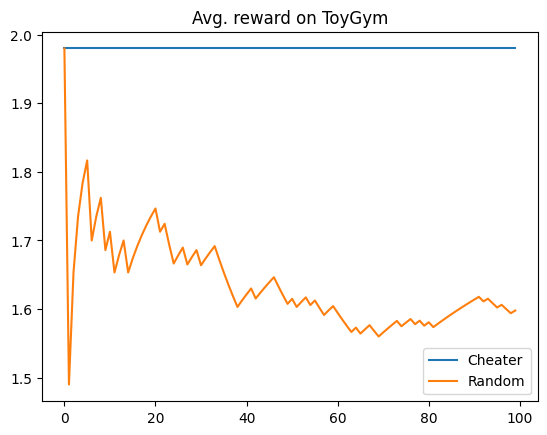

In [111]:
class Cheater(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env, config, gamma, seed)
        # self.env = env
        # self.reset(seed)
        # self.config = config
        # self.gamma = gamma
        # self.num_actions = env.action_space.n
        # self.num_states = env.observation_space.n
        # self.name = type(self).__name__
        self.pi = find_optimal_policy(self.env.unwrapped.env, gamma=self.gamma)

    def get_action(self, obs):
        return self.pi[obs]
        



if MAIN:
    env_toy = gym.make("ToyGym-v0")
    agents_toy = [Cheater(env_toy), Random(env_toy)]
    for agent in agents_toy:
        returns = agent.train(n_runs=100)
        plt.plot(utils.cummean(returns), label=agent.name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

0.1


100%|██████████| 1000/1000 [00:00<00:00, 2139.36it/s]


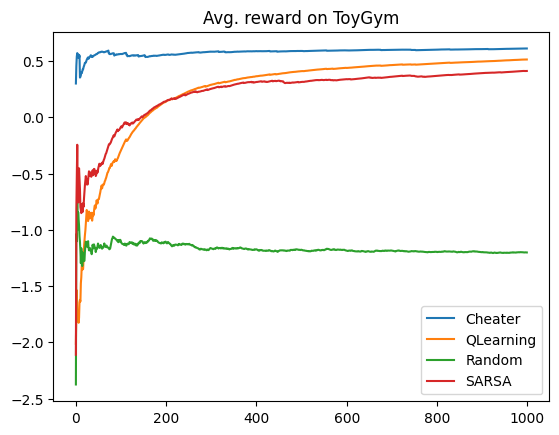

In [112]:
class QLearning(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env, config, gamma, seed)
        self.Q = np.zeros((self.num_states, self.num_actions))
        print(self.config.epsilon)

    def get_action(self, obs: ObsType) -> ActType:
        if self.rng.random() < self.config.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return np.argmax(self.Q[obs])
            
    def observe(self, exp: Experience) -> None:
        self.Q[exp.obs, exp.act] += self.config.lr * (exp.reward + self.gamma * np.max(self.Q[exp.new_obs]) - self.Q[exp.obs, exp.act])

class SARSA(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env, config, gamma, seed)
        self.Q = np.zeros((self.num_states, self.num_actions))

    def get_action(self, obs: ObsType) -> ActType:
        if self.rng.random() < self.config.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return np.argmax(self.Q[obs])

        #     '''A class for storing one piece of experience during an episode run'''
        # obs: ObsType
        # act: ActType
        # reward: float
        # new_obs: ObsType
        # new_act: Optional[ActType] = None
    def observe(self, exp: Experience) -> None:
        new_act = exp.new_act or exp.act
        self.Q[exp.obs, exp.act] += self.config.lr * (exp.reward + self.gamma * self.Q[exp.new_obs, new_act] - self.Q[exp.obs, exp.act])

if MAIN:
    env_norvig: DiscreteEnviroGym = gym.make("NorvigGrid-v0")
    n_runs = 1000
    gamma = 0.99
    seed = 1
    config_norvig = AgentConfig()
    args_nor = (env_norvig, config_norvig, gamma, seed)
    # [Cheater(*args_nor), QLearning(*args_nor), SARSA(*args_nor), Random(*args_nor)]
    agents_norvig = []
    agents_norvig.append(Cheater(*args_nor))
    agents_norvig.append(QLearning(*args_nor))
    agents_norvig.append(Random(*args_nor))
    agents_norvig.append(SARSA(*args_nor))

    # bargs = [(env_norvig, conf, gamma, seed) for conf in [AgentConfig(epsilon=eps) for eps in [0.0, 0.1, 0.5, 20]]]
    # bgents_norvig = [QLearning(*args) for args in bargs]
    # agents_norvig.extend(bgents_norvig)
    
    
    returns_norvig = {}
    for agent in agents_norvig:
        returns_norvig[agent.name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()


0
0.01
0.05
0.1


100%|██████████| 1000/1000 [00:00<00:00, 2291.41it/s]


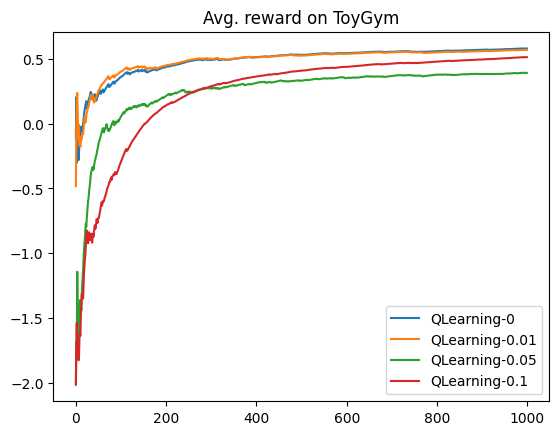

In [113]:
if MAIN:
    env_norvig: DiscreteEnviroGym = gym.make("NorvigGrid-v0")
    n_runs = 1000
    gamma = 0.99
    seed = 1
    config_norvig = AgentConfig()
    configs_eps = [AgentConfig(epsilon=eps) for eps in [0, 0.01, 0.05, 0.1]]
    args_eps = [(env_norvig, cfg, gamma, seed) for cfg in configs_eps]
    agents_eps = [QLearning(*args) for args in args_eps]
    args_nor = (env_norvig, config_norvig, gamma, seed)
    # agents_norvig = []
    # agents_norvig.append(Cheater(*args_nor))
    # agents_norvig.append(QLearning(*args_nor))
    # agents_norvig.append(Random(*args_nor))
    # agents_norvig.append(SARSA(*args_nor))
    agents_norvig = agents_eps

    # bargs = [(env_norvig, conf, gamma, seed) for conf in [AgentConfig(epsilon=eps) for eps in [0.0, 0.1, 0.5, 20]]]
    # bgents_norvig = [QLearning(*args) for args in bargs]
    # agents_norvig.extend(bgents_norvig)
    
    
    returns_norvig = {}
    for agent in agents_norvig:
        new_name = f'{agent.name}-{agent.config.epsilon}'
        returns_norvig[new_name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = f'{agent.name}-{agent.config.epsilon}'
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

In [115]:
! pip3 install pygame
env_norvig = gym.make("CliffWalking-v0")

  Using cached pygame-2.1.2-cp39-cp39-macosx_11_0_arm64.whl (8.4 MB)
You should consider upgrading via the '/Users/jon/ml/arena/venv/bin/python3 -m pip install --upgrade pip' command.


In [127]:
import plotly.express as px

def show_cliff_value(Q: Arr, title: Optional[str] = None):
    '''
    Displays the value of each state in CliffWalking-v0 given a Q-value table.
    '''
    V = Q.max(axis=-1).reshape(4, 12)
    fig = px.imshow(V, text_auto=".2f", title=title)
    fig.show()

def show_cliff_policy(Q: Arr):
    '''
    Displays the greedy policy for CliffWalking-v0 given a Q-value table.
    '''
    pi = Q.argmax(axis=-1).reshape((4, 12))
    objects = {(3, 0): "green", (3, 11): "red"} | {(3, i): "black" for i in range(1, 11)}
    img = Image.new(mode="RGB", size=(1200, 400), color="white")
    draw = ImageDraw.Draw(img)
    for x in range(0, img.width+1, 100):
        draw.line([(x, 0), (x, img.height)], fill="black", width=4)
    for y in range(0, img.height+1, 100):
        draw.line([(0, y), (img.width, y)], fill="black", width=4)
    for x in range(12):
        for y in range(4):
            draw.regular_polygon((50+x*100, 50+y*100, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
            if (y, x) in objects:
                draw.regular_polygon((50+x*100, 50+y*100, 40), 4, fill=objects[(y, x)])
    display(img.resize((600, 200)))

0
0.01
0.05
0.1
0.1


100%|██████████| 1000/1000 [00:00<00:00, 5981.51it/s]


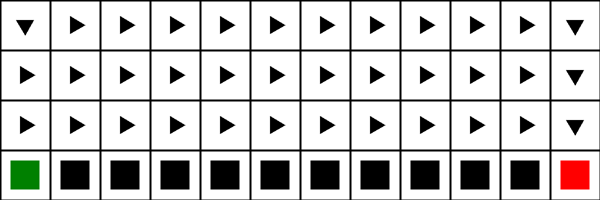

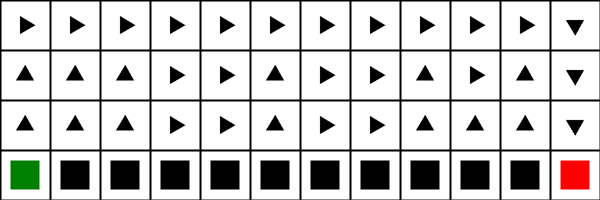

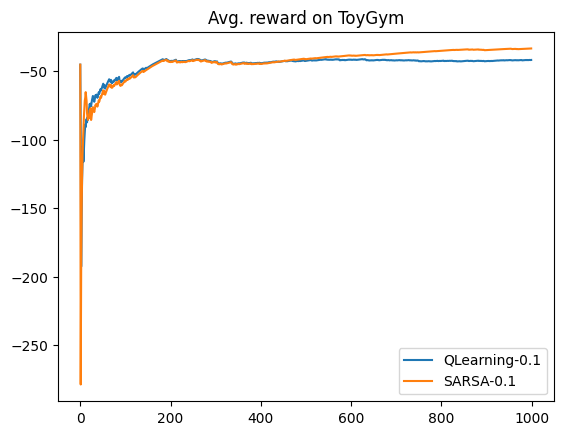

In [129]:
if MAIN:
    env_norvig: DiscreteEnviroGym = gym.make("CliffWalking-v0")
    n_runs = 1000
    gamma = 0.99
    seed = 1
    config_norvig = AgentConfig(lr=1)
    configs_eps = [AgentConfig(epsilon=eps) for eps in [0, 0.01, 0.05, 0.1]]
    args_eps = [(env_norvig, cfg, gamma, seed) for cfg in configs_eps]
    agents_eps = [QLearning(*args) for args in args_eps]
    args_nor = (env_norvig, config_norvig, gamma, seed)
    agents_norvig = []
    # agents_norvig.append(Cheater(*args_nor))
    agents_norvig.append(QLearning(*args_nor))
    # agents_norvig.append(Random(*args_nor))
    agents_norvig.append(SARSA(*args_nor))
    # agents_norvig = agents_eps

    # bargs = [(env_norvig, conf, gamma, seed) for conf in [AgentConfig(epsilon=eps) for eps in [0.0, 0.1, 0.5, 20]]]
    # bgents_norvig = [QLearning(*args) for args in bargs]
    # agents_norvig.extend(bgents_norvig)
    
    
    returns_norvig = {}
    for agent in agents_norvig:
        new_name = f'{agent.name}-{agent.config.epsilon}'
        returns_norvig[new_name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = f'{agent.name}-{agent.config.epsilon}'
        show_cliff_value(agent.Q, title=name)
        show_cliff_policy(agent.Q)
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()